In [2]:
# Import required packages
import numpy as np
import cv2
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input, BatchNormalization, Activation, InputLayer
from keras.utils import np_utils
from sklearn.model_selection import KFold

import os
import time

## 1. Load the datasets

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`. 

In [3]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'../data/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('../data/noisy_labels.csv', delimiter=',', dtype="int8")

For illustration, we present a small subset (of size 8) of the images with their clean and noisy labels in `clean_noisy_trainset`. You are encouraged to explore more characteristics of the label noises on the whole dataset. 

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


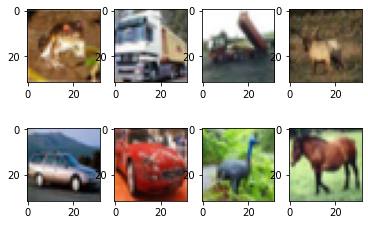

In [4]:
# [DO NOT MODIFY THIS CELL]

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))


## 2. The predictive model

We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### 2.1. Baseline Model

In [5]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [6]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

In [7]:
# [DO NOT MODIFY THIS CELL]
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

### 2.2. Model I

LeNet 5 is the one of most famous convolutional neural network designed to recognize handwritten digits from images.

It consists of 5 layers, including three convolutional layers, two subsampling layers, and two fully connected layers.

We add dropout to avoid overfitting

In [8]:
# [BUILD A MORE SOPHISTICATED PREDICTIVE MODEL]

# write your code here...

np.random.seed(5243_1)

# split the data into training and validation sets basing on the noisy labels and clean labels
imgs = imgs.astype('float32') /255.0

# Clean data
x_clean = imgs[0:10000]
y_clean = clean_labels

# Noisy data
x_noisy = imgs[10000:]
y_noisy = noisy_labels[10000:]

x_train_noisy, x_val_noisy, y_train_noisy, y_val_noisy = train_test_split(imgs[10000:], noisy_labels[10000:], test_size=0.2, random_state=42)

x_train_clean, x_val_clean, y_train_clean, y_val_clean = train_test_split(imgs[0:10000], clean_labels, test_size=0.2, random_state=42)


In [9]:
# Model 1: LeNet 5 
np.random.seed(5243_2)
model1 = Sequential()
model1.add(Conv2D(filters=6, kernel_size=(5,5), padding='same', activation='relu', input_shape=(32, 32, 3)))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Dropout(0.3))
model1.add(Conv2D(filters=16, kernel_size=(5,5), padding = 'valid' , activation='relu'))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Dropout(0.3))
model1.add(Conv2D(filters=120, kernel_size=(5,5), padding = 'valid' , activation='relu'))
model1.add(Flatten())
model1.add(Dropout(0.3))
model1.add(Dense(84, activation='relu'))
model1.add(Dropout(0.3))
model1.add(Dense(10, activation='softmax'))

model1.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

filepath='model1_weights.best.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True,mode='max')
callbacks_list = [checkpoint]

Model1_history_callback = model1.fit(x_train_noisy, y_train_noisy, batch_size = 128, epochs = 40, validation_data = (x_val_noisy, y_val_noisy), callbacks=callbacks_list)

Epoch 1/40
250/250 [==============================] - ETA: 0s - loss: 2.2972 - accuracy: 0.1161
Epoch 1: val_accuracy improved from -inf to 0.12962, saving model to model1_weights.best.hdf5
250/250 [==============================] - 32s 119ms/step - loss: 2.2972 - accuracy: 0.1161 - val_loss: 2.2883 - val_accuracy: 0.1296
Epoch 2/40
250/250 [==============================] - ETA: 0s - loss: 2.2740 - accuracy: 0.1480
Epoch 2: val_accuracy improved from 0.12962 to 0.14762, saving model to model1_weights.best.hdf5
250/250 [==============================] - 23s 93ms/step - loss: 2.2740 - accuracy: 0.1480 - val_loss: 2.2742 - val_accuracy: 0.1476
Epoch 3/40
250/250 [==============================] - ETA: 0s - loss: 2.2643 - accuracy: 0.1596
Epoch 3: val_accuracy improved from 0.14762 to 0.16688, saving model to model1_weights.best.hdf5
250/250 [==============================] - 25s 99ms/step - loss: 2.2643 - accuracy: 0.1596 - val_loss: 2.2635 - val_accuracy: 0.1669
Epoch 4/40
250/250 [====

In [10]:
# Load the best weights from the training

model1 = Sequential()
model1.add(Conv2D(filters=6, kernel_size=(5,5), padding='same', activation='relu', input_shape=(32, 32, 3)))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Dropout(0.3))
model1.add(Conv2D(filters=16, kernel_size=(5,5), padding = 'valid' , activation='relu'))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Dropout(0.3))
model1.add(Conv2D(filters=120, kernel_size=(5,5), padding = 'valid' , activation='relu'))
model1.add(Flatten())
model1.add(Dropout(0.3))
model1.add(Dense(84, activation='relu'))
model1.add(Dropout(0.3))
model1.add(Dense(10, activation='softmax'))

model1.load_weights('model1_weights.best.hdf5')
model1.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

# Evaluate the model on the test data
test_loss, test_acc = model1.evaluate(x_clean, y_clean, verbose=0)
print('Test accuracy:', test_acc, 'Test loss:', test_loss)

Test accuracy: 0.4742000102996826 Test loss: 1.8490393161773682


The accuracy of model 1 is 49%, which is better a lot than the baseline model.

In [11]:
def model_I(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    # write your code here...
    
    img=image.reshape(1,32,32,3)/255.0
    prediction=model1.predict(img)
    return np.argmax(prediction)

### 2.3. Model II

### 2.3.1 Label Correction

In [12]:
# [ADD WEAKLY SUPERVISED LEARNING FEATURE TO MODEL I]

# write your code here...
np.random.seed(5243_3)
label_correction_model =Sequential(
        [
            InputLayer(input_shape=(32, 32, 3)),
            Conv2D(filters=32, kernel_size=3, activation='relu'),
            MaxPool2D(pool_size=(2, 2), padding='same'),
            Dropout(0.3),
            Conv2D(filters=64, kernel_size=3, activation='relu'),
            BatchNormalization(momentum=0.9),
            MaxPool2D(pool_size=(2, 2), padding='same'),
            Dropout(0.3),
            Conv2D(filters=128, kernel_size=3, activation='relu'),
            MaxPool2D(pool_size=(2, 2), padding='same'),
            Dropout(0.3),
            Conv2D(filters=256, kernel_size=3, activation='relu'),
            BatchNormalization(momentum=0.9),
            Flatten(),
            Dropout(0.3),
            Dense(64, activation = 'relu'),
            Dropout(0.3),
            Dense(10, activation = 'softmax')
        ])
filepath='lcn_weights.best.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True,mode='max')
callbacks_list_2 = [checkpoint]
label_correction_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

label_correction_model_history_callback = label_correction_model.fit(x_train_clean, y_train_clean, epochs=40, validation_data = (x_val_clean, y_val_clean), callbacks=callbacks_list_2)


Epoch 1/40
249/250 [============================>.] - ETA: 0s - loss: 2.2085 - accuracy: 0.2383
Epoch 1: val_accuracy improved from -inf to 0.30750, saving model to lcn_weights.best.hdf5
250/250 [==============================] - 13s 46ms/step - loss: 2.2072 - accuracy: 0.2385 - val_loss: 1.8975 - val_accuracy: 0.3075
Epoch 2/40
249/250 [============================>.] - ETA: 0s - loss: 1.7848 - accuracy: 0.3524
Epoch 2: val_accuracy improved from 0.30750 to 0.42550, saving model to lcn_weights.best.hdf5
250/250 [==============================] - 11s 44ms/step - loss: 1.7828 - accuracy: 0.3531 - val_loss: 1.5434 - val_accuracy: 0.4255
Epoch 3/40
250/250 [==============================] - ETA: 0s - loss: 1.6314 - accuracy: 0.4027
Epoch 3: val_accuracy improved from 0.42550 to 0.42850, saving model to lcn_weights.best.hdf5
250/250 [==============================] - 11s 44ms/step - loss: 1.6314 - accuracy: 0.4027 - val_loss: 1.5961 - val_accuracy: 0.4285
Epoch 4/40
249/250 [==============

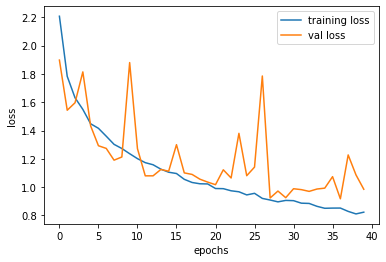

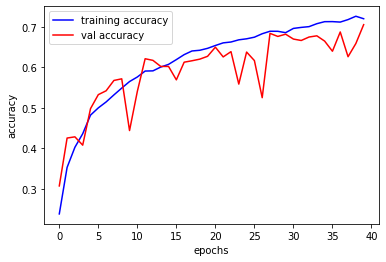

In [13]:
hist = pd.DataFrame(label_correction_model_history_callback.history)
# fig, ax = plt.subplots()
plt.plot(hist.index, hist['loss'], label ='training loss')
plt.plot(hist.index, hist['val_loss'], label = 'val loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

# ax2 = ax.twinx()
plt.plot(hist.index, hist['accuracy'], '-b', label = 'training accuracy')
plt.plot(hist.index, hist['val_accuracy'], '-r', label = 'val accuracy')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.show()

In [14]:
label_correction_model =Sequential(
        [
            InputLayer(input_shape=(32, 32, 3)),
            Conv2D(filters=32, kernel_size=3, activation='relu'),
            MaxPool2D(pool_size=(2, 2), padding='same'),
            Dropout(0.3),
            Conv2D(filters=64, kernel_size=3, activation='relu'),
            BatchNormalization(momentum=0.9),
            MaxPool2D(pool_size=(2, 2), padding='same'),
            Dropout(0.3),
            Conv2D(filters=128, kernel_size=3, activation='relu'),
            MaxPool2D(pool_size=(2, 2), padding='same'),
            Dropout(0.3),
            Conv2D(filters=256, kernel_size=3, activation='relu'),
            BatchNormalization(momentum=0.9),
            Flatten(),
            Dropout(0.3),
            Dense(64, activation = 'relu'),
            Dropout(0.3),
            Dense(10, activation = 'softmax')
        ])
label_correction_model.load_weights('lcn_weights.best.hdf5')
label_correction_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [15]:
label_correction_model.evaluate(x_val_clean, y_val_clean)

63/63 [==============================] - 1s 9ms/step - loss: 0.9852 - accuracy: 0.7050


[0.9852386116981506, 0.7049999833106995]

In [16]:
cleansed_y_labels_train = label_correction_model.predict(x_train_noisy)
cleansed_y_labels_train = np.array([np.argmax(i) for i in cleansed_y_labels_train])

cleansed_y_labels_val = label_correction_model.predict(x_val_noisy)
cleansed_y_labels_val = np.array([np.argmax(i) for i in cleansed_y_labels_val])

cleansed_y_labels = label_correction_model.predict(x_noisy)
cleansed_y_labels = np.array([np.argmax(i) for i in cleansed_y_labels])

1250/1250 [==============================] - 10s 8ms/step


### Training Model 1 with cleaned label

The accuracy of the model 2 on the clean data set is 

In [17]:
def create_model2():
    np.random.seed(5243_3)
    model2 = Sequential()
    model2.add(Conv2D(filters=6, kernel_size=(5,5), padding='same', activation='relu', input_shape=(32, 32, 3)))
    model2.add(MaxPool2D(pool_size=(2,2)))
    model2.add(Dropout(0.3))
    model2.add(Conv2D(filters=16, kernel_size=(5,5), padding = 'valid' , activation='relu'))
    model2.add(MaxPool2D(pool_size=(2,2)))
    model2.add(Dropout(0.3))
    model2.add(Conv2D(filters=120, kernel_size=(5,5), padding = 'valid' , activation='relu'))
    model2.add(Flatten())
    model2.add(Dropout(0.3))
    model2.add(Dense(84, activation='relu'))
    model2.add(Dropout(0.3))
    model2.add(Dense(10, activation='softmax'))

    model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

    return model2

In [18]:
# Define the number of folds for cross-validation
num_folds = 5

# Define the K-Fold cross-validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# Initialize arrays to store the validation accuracies and losses for each fold
val_accs = []
val_losses = []
h=[]

filepath='model2_weights.best.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True,mode='max')
callbacks_list_3 = [checkpoint]

# Loop over the folds
for fold_idx, (train_indices, val_indices) in enumerate(kfold.split(x_noisy, y_noisy)):
    print('Training on fold', fold_idx+1)

    # Create a new instance of the model for each fold
    model = create_model2()

    # Compile the model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Fit the model to the training data for this fold
    history = model.fit(x_noisy[train_indices], cleansed_y_labels[train_indices], batch_size=128, epochs=40, verbose=1, validation_data=(x_noisy[val_indices], cleansed_y_labels[val_indices]), callbacks=callbacks_list_3)
    h.append(history)
    
    # Evaluate the model on the validation data for this fold
    val_loss, val_acc = model.evaluate(x_clean, y_clean, verbose=0)
    print('Validation accuracy:', val_acc, 'Validation loss:', val_loss)
    
    # Store the validation accuracy and loss for this fold
    val_accs.append(val_acc)
    val_losses.append(val_loss)

# Print the average validation accuracy and loss over all folds
print('Average validation accuracy:', np.mean(val_accs))
print('Average validation loss:', np.mean(val_losses))

Training on fold 1
Epoch 1/40
250/250 [==============================] - ETA: 0s - loss: 1.9758 - accuracy: 0.2646
Epoch 1: val_accuracy improved from 0.21663 to 0.37775, saving model to model1_weights.best.hdf5
250/250 [==============================] - 14s 51ms/step - loss: 1.9758 - accuracy: 0.2646 - val_loss: 1.7848 - val_accuracy: 0.3778
Epoch 2/40
250/250 [==============================] - ETA: 0s - loss: 1.6078 - accuracy: 0.4094
Epoch 2: val_accuracy improved from 0.37775 to 0.50287, saving model to model1_weights.best.hdf5
250/250 [==============================] - 13s 52ms/step - loss: 1.6078 - accuracy: 0.4094 - val_loss: 1.3911 - val_accuracy: 0.5029
Epoch 3/40
249/250 [============================>.] - ETA: 0s - loss: 1.4200 - accuracy: 0.4837
Epoch 3: val_accuracy improved from 0.50287 to 0.52950, saving model to model1_weights.best.hdf5
250/250 [==============================] - 13s 53ms/step - loss: 1.4199 - accuracy: 0.4837 - val_loss: 1.2686 - val_accuracy: 0.5295
Epo

By applying cross validation to model 2, we can find that the model 2 has similiar performance on each train and validation data set.


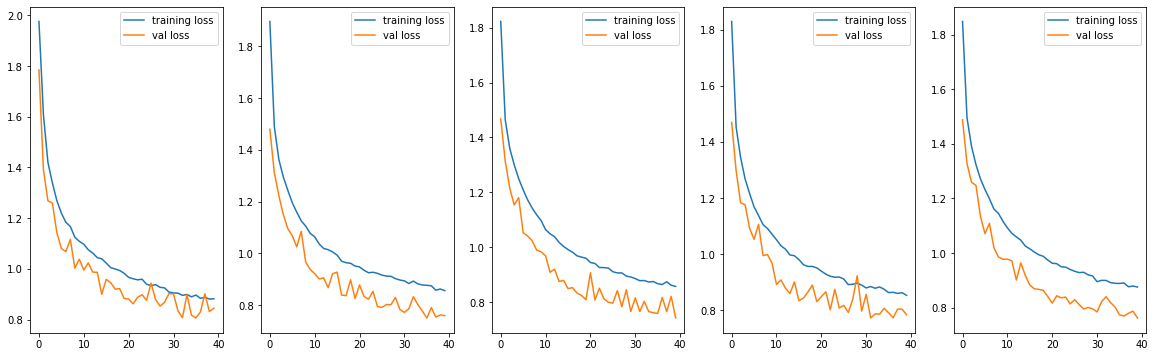

In [19]:
# Plot the training and validation loss for each fold
fig = plt.figure(figsize=(20,6))
hist = pd.DataFrame(h[0].history)
ax1 = fig.add_subplot(1,5,1)
ax1.plot(hist.index, hist['loss'], label ='training loss')
ax1.plot(hist.index, hist['val_loss'], label ='val loss')
ax1.legend()


hist = pd.DataFrame(h[1].history)
ax1 = fig.add_subplot(1,5,2)
ax1.plot(hist.index, hist['loss'], label ='training loss')
ax1.plot(hist.index, hist['val_loss'], label ='val loss')
ax1.legend()


hist = pd.DataFrame(h[2].history)
ax1 = fig.add_subplot(1,5,3)
ax1.plot(hist.index, hist['loss'], label ='training loss')
ax1.plot(hist.index, hist['val_loss'], label ='val loss')
ax1.legend()


hist = pd.DataFrame(h[3].history)
ax1 = fig.add_subplot(1,5,4)
ax1.plot(hist.index, hist['loss'], label ='training loss')
ax1.plot(hist.index, hist['val_loss'], label ='val loss')
ax1.legend()


hist = pd.DataFrame(h[4].history)
ax1 = fig.add_subplot(1,5,5)
ax1.plot(hist.index, hist['loss'], label ='training loss')
ax1.plot(hist.index, hist['val_loss'], label ='val loss')
ax1.legend()


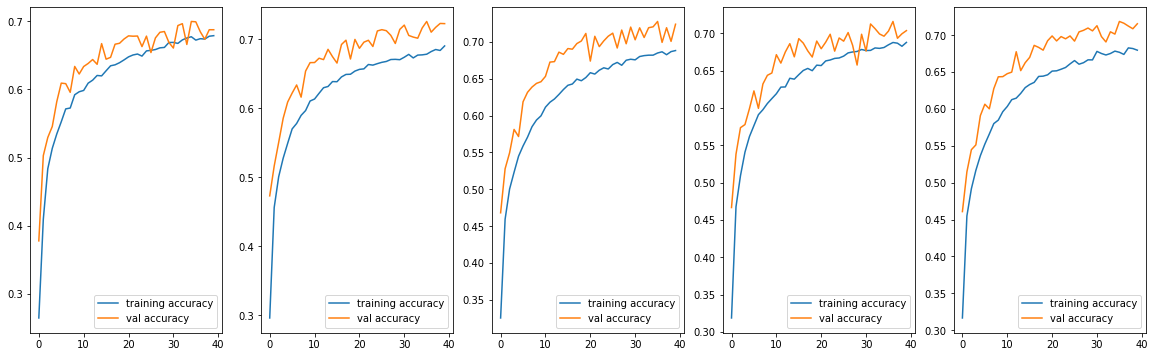

In [20]:
# Plot the training and validation accuracy for each fold
fig = plt.figure(figsize=(20,6))
hist = pd.DataFrame(h[0].history)
ax1 = fig.add_subplot(1,5,1)
ax1.plot(hist.index, hist['accuracy'], label ='training accuracy')
ax1.plot(hist.index, hist['val_accuracy'], label ='val accuracy')
ax1.legend()


hist = pd.DataFrame(h[1].history)
ax1 = fig.add_subplot(1,5,2)
ax1.plot(hist.index, hist['accuracy'], label ='training accuracy')
ax1.plot(hist.index, hist['val_accuracy'], label ='val accuracy')
ax1.legend()


hist = pd.DataFrame(h[2].history)
ax1 = fig.add_subplot(1,5,3)
ax1.plot(hist.index, hist['accuracy'], label ='training accuracy')
ax1.plot(hist.index, hist['val_accuracy'], label ='val accuracy')
ax1.legend()


hist = pd.DataFrame(h[3].history)
ax1 = fig.add_subplot(1,5,4)
ax1.plot(hist.index, hist['accuracy'], label ='training accuracy')
ax1.plot(hist.index, hist['val_accuracy'], label ='val accuracy')
ax1.legend()


hist = pd.DataFrame(h[4].history)
ax1 = fig.add_subplot(1,5,5)
ax1.plot(hist.index, hist['accuracy'], label ='training accuracy')
ax1.plot(hist.index, hist['val_accuracy'], label ='val accuracy')
ax1.legend()

In [24]:
# Load the best weights from the model 2 training

model2 = Sequential()
model2.add(Conv2D(filters=6, kernel_size=(5,5), padding='same', activation='relu', input_shape=(32, 32, 3)))
model2.add(MaxPool2D(pool_size=(2,2)))
model2.add(Dropout(0.3))
model2.add(Conv2D(filters=16, kernel_size=(5,5), padding = 'valid' , activation='relu'))
model2.add(MaxPool2D(pool_size=(2,2)))
model2.add(Dropout(0.3))
model2.add(Conv2D(filters=120, kernel_size=(5,5), padding = 'valid' , activation='relu'))
model2.add(Flatten())
model2.add(Dropout(0.3))
model2.add(Dense(84, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(10, activation='softmax'))

model2.load_weights(filepath)

model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

# Evaluate the model on the test data
test_loss, test_acc = model2.evaluate(x_clean, y_clean, verbose=0)
print('Test accuracy:', test_acc, 'Test loss:', test_loss)

Test accuracy: 0.6097000241279602 Test loss: 1.250930666923523


In [28]:
def model_II(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    # write your code here...
    
    img=image.reshape(1,32,32,3)/255.0
    prediction=model2.predict(img)
    return np.argmax(prediction)

## 3. Evaluation

For assessment, we will evaluate your final model on a hidden test dataset with clean labels by the `evaluation` function defined as follows. Although you will not have the access to the test set, the function would be useful for the model developments. For example, you can split the small training set, using one portion for weakly supervised learning and the other for validation purpose. 

In [26]:
# [DO NOT MODIFY THIS CELL]
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

In [ ]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 10000
test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/test{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
evaluation(baseline_model, test_labels, test_imgs)

The overall accuracy is $0.24$, which is better than random guess (which should have a accuracy around $0.10$). For the project, you should try to improve the performance by the following strategies:

- Consider a better choice of model architectures, hyperparameters, or training scheme for the predictive model;
- Use both `clean_noisy_trainset` and `noisy_trainset` for model training via **weakly supervised learning** methods. One possible solution is to train a "label-correction" model using the former, correct the labels in the latter, and train the final predictive model using the corrected dataset.
- Apply techniques such as $k$-fold cross validation to avoid overfitting;
- Any other reasonable strategies.